In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
# Example: Load dataset
data = pd.read_csv('tweets.csv')

# Preview data
print(data.head())


             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnar

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize and remove stopwords + lemmatize
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['clean_text'] = data['text'].apply(preprocess_text)
print(data[['text', 'clean_text']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...


                                                text  \
0                @VirginAmerica What @dhepburn said.   
1  @VirginAmerica plus you've added commercials t...   
2  @VirginAmerica I didn't today... Must mean I n...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   

                                          clean_text  
0                                               said  
1       plus youve added commercial experience tacky  
2       didnt today must mean need take another trip  
3  really aggressive blast obnoxious entertainmen...  
4                               really big bad thing  


In [6]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['clean_text']).toarray()
y = data['airline_sentiment']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [9]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7967896174863388
Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.94      0.88      1889
     neutral       0.66      0.49      0.56       580
    positive       0.82      0.60      0.69       459

    accuracy                           0.80      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928

Confusion Matrix:
 [[1772   88   29]
 [ 263  286   31]
 [ 124   60  275]]


In [10]:
# Show top positive and negative features
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

top_positive_coefficients = np.argsort(coefficients)[-10:]
top_negative_coefficients = np.argsort(coefficients)[:10]

print("Top positive words:")
for i in top_positive_coefficients:
    print(feature_names[i], coefficients[i])

print("\nTop negative words:")
for i in top_negative_coefficients:
    print(feature_names[i], coefficients[i])


Top positive words:
hold 2.1630334127430917
delay 2.1847323526310003
fix 2.344962389243673
luggage 2.357033569608388
cancelled 2.37775457274417
bag 2.3988924752323637
hr 2.778418413561737
delayed 2.835248039176713
worst 3.099315391298192
hour 4.154345618386617

Top negative words:
thank -4.05344270428253
thanks -3.6319750542675
love -2.1548788408123842
great -2.092855989178047
awesome -1.9897386629561526
amazing -1.8934461970423835
best -1.7795514139951771
kudos -1.59533911355939
dal -1.4375452403422926
excellent -1.3971716337075062


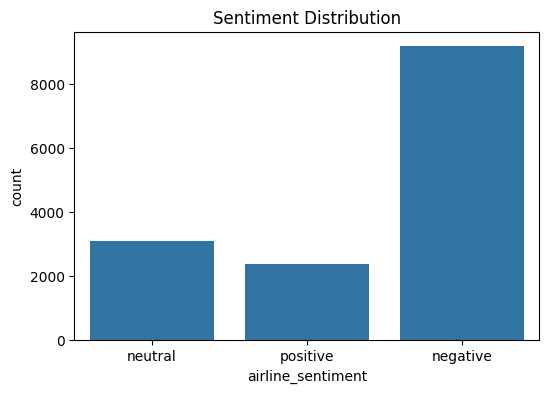

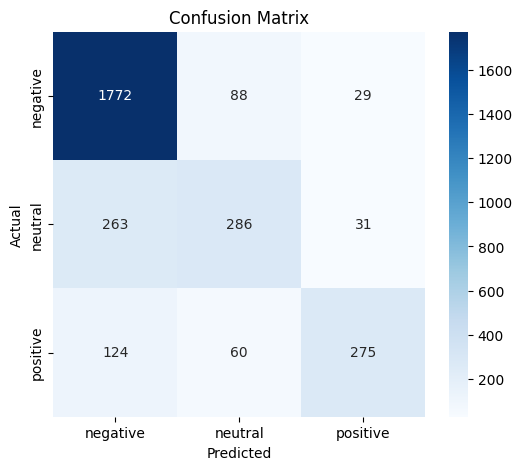


Top positive words for 'negative':
hour 4.154
worst 3.099
delayed 2.835
hr 2.778
bag 2.399
cancelled 2.378
luggage 2.357
fix 2.345
delay 2.185
hold 2.163

Top positive words for 'neutral':
hi 1.817
winner 1.286
dal 1.259
carry 1.237
atlanta 1.232
dm 1.207
chance 1.199
march 1.189
number 1.165
photo 1.129

Top positive words for 'positive':
thanks 4.292
thank 4.172
great 4.091
awesome 3.480
amazing 3.209
best 3.050
love 2.929
appreciate 2.502
excellent 2.467
thx 2.341


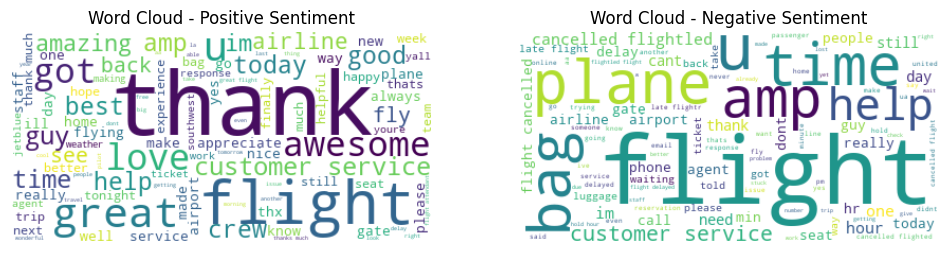

In [15]:
# Visualization: Sentiment Distribution (fixed)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=data)  # Removed palette to avoid warning
plt.title('Sentiment Distribution')
plt.show()

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Top Words Influencing Sentiment
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_

for i, class_label in enumerate(model.classes_):
    print(f"\nTop positive words for '{class_label}':")
    top_pos_coeff = np.argsort(coefficients[i])[-10:]
    for idx in reversed(top_pos_coeff):
        print(feature_names[idx], f"{coefficients[i][idx]:.3f}")

# Word Clouds for Positive and Negative Sentiments
from wordcloud import WordCloud

positive_text = ' '.join(data[data['airline_sentiment']=='positive']['clean_text'])
negative_text = ' '.join(data[data['airline_sentiment']=='negative']['clean_text'])

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
wc_pos = WordCloud(background_color='white', max_words=100).generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.title('Word Cloud - Positive Sentiment')
plt.axis('off')

plt.subplot(1,2,2)
wc_neg = WordCloud(background_color='white', max_words=100).generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.title('Word Cloud - Negative Sentiment')
plt.axis('off')

plt.show()
